In [ ]:
import torch
import torchvision
import torchvision.transforms as transform
from torch.utils.data import DataLoader, Dataset
import os
import matplotlib.pyplot as plt
import numpy as np
import random
from google.colab import drive
drive.mount('/content/drive')
from torchvision import datasets, transforms

Mounted at /content/drive


In [ ]:
# import torchvision.transforms.functional as F

# class edgeDetect:
#     def __call__(self, image):        
#         import cv2
#         img_blur = cv2.GaussianBlur(image, (3, 3), 0) # Gaussian blur the image
#         edges = cv2.Canny(image=img_blur, threshold1=100, threshold2=200)  # Canny Edge Detection
#         kernel = np.ones((5,5), np.uint8)
#         image = cv2.dilate(edges, kernel, iterations=1)
#         plt.imshow(image)
#         plt.show()
#         return image


In [ ]:
import helper
import matplotlib.pyplot as plt
train_dir = 'drive/MyDrive/Colab Notebooks/Train1'
test_dir = 'drive/MyDrive/Colab Notebooks/Test'
target_image_size = (600, 400)
transform = transforms.Compose([                               
transforms.Resize(target_image_size),                                
transforms.RandomHorizontalFlip(),
transforms.ToTensor(),
transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
train_dataset = datasets.ImageFolder(train_dir,transform=transform)
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=2)

classes = os.listdir('drive/MyDrive/Colab Notebooks/Train1')
classes.sort()
classes = tuple(classes)
print(len(classes))

18


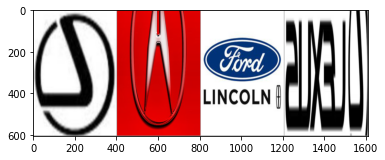

Lexus Acura Ford  Lexus


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
batch_size = 4

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
# print(labels)
# show images
imshow(torchvision.utils.make_grid(images))
# print labels

print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        # self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc1 = nn.Linear(228144, 120)        
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 18)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [ ]:

import torch.optim as optim

criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
# optimizer = optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08)
optimizer = optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)

In [ ]:
for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

Finished Training


In [ ]:
PATH = 'drive/MyDrive/Colab Notebooks/logo.pth'
torch.save(net.state_dict(), PATH)

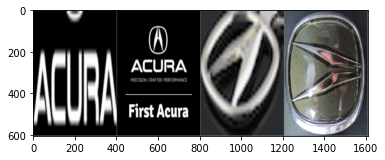

GroundTruth:  Acura Acura Acura Acura


In [ ]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [ ]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [ ]:
outputs = net(images)

In [ ]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  Lexus Lexus Mazda Mazda


In [ ]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 18 %


In [ ]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
accuracy_per_class = []
class_name = []
for classname, correct_count in correct_pred.items():
    accuracy = 100*float(correct_count) / total_pred[classname]
    accuracy_per_class.append(accuracy)
    class_name.append(classname)
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: Acura is 0.0 %
Accuracy for class: Audi  is 0.0 %
Accuracy for class: BMW   is 33.3 %
Accuracy for class: Chevrolet is 20.0 %
Accuracy for class: Ford  is 50.0 %
Accuracy for class: Honda is 0.0 %
Accuracy for class: Hyundai is 14.3 %
Accuracy for class: Infiniti is 0.0 %
Accuracy for class: KIA   is 60.0 %
Accuracy for class: Lamborghini is 60.0 %
Accuracy for class: Lexus is 0.0 %
Accuracy for class: Mazda is 14.3 %
Accuracy for class: MercedesBenz is 60.0 %
Accuracy for class: Nissan is 20.0 %
Accuracy for class: Porsche is 20.0 %
Accuracy for class: Tesla is 16.7 %
Accuracy for class: Toyota is 0.0 %
Accuracy for class: Volkswagen is 16.7 %


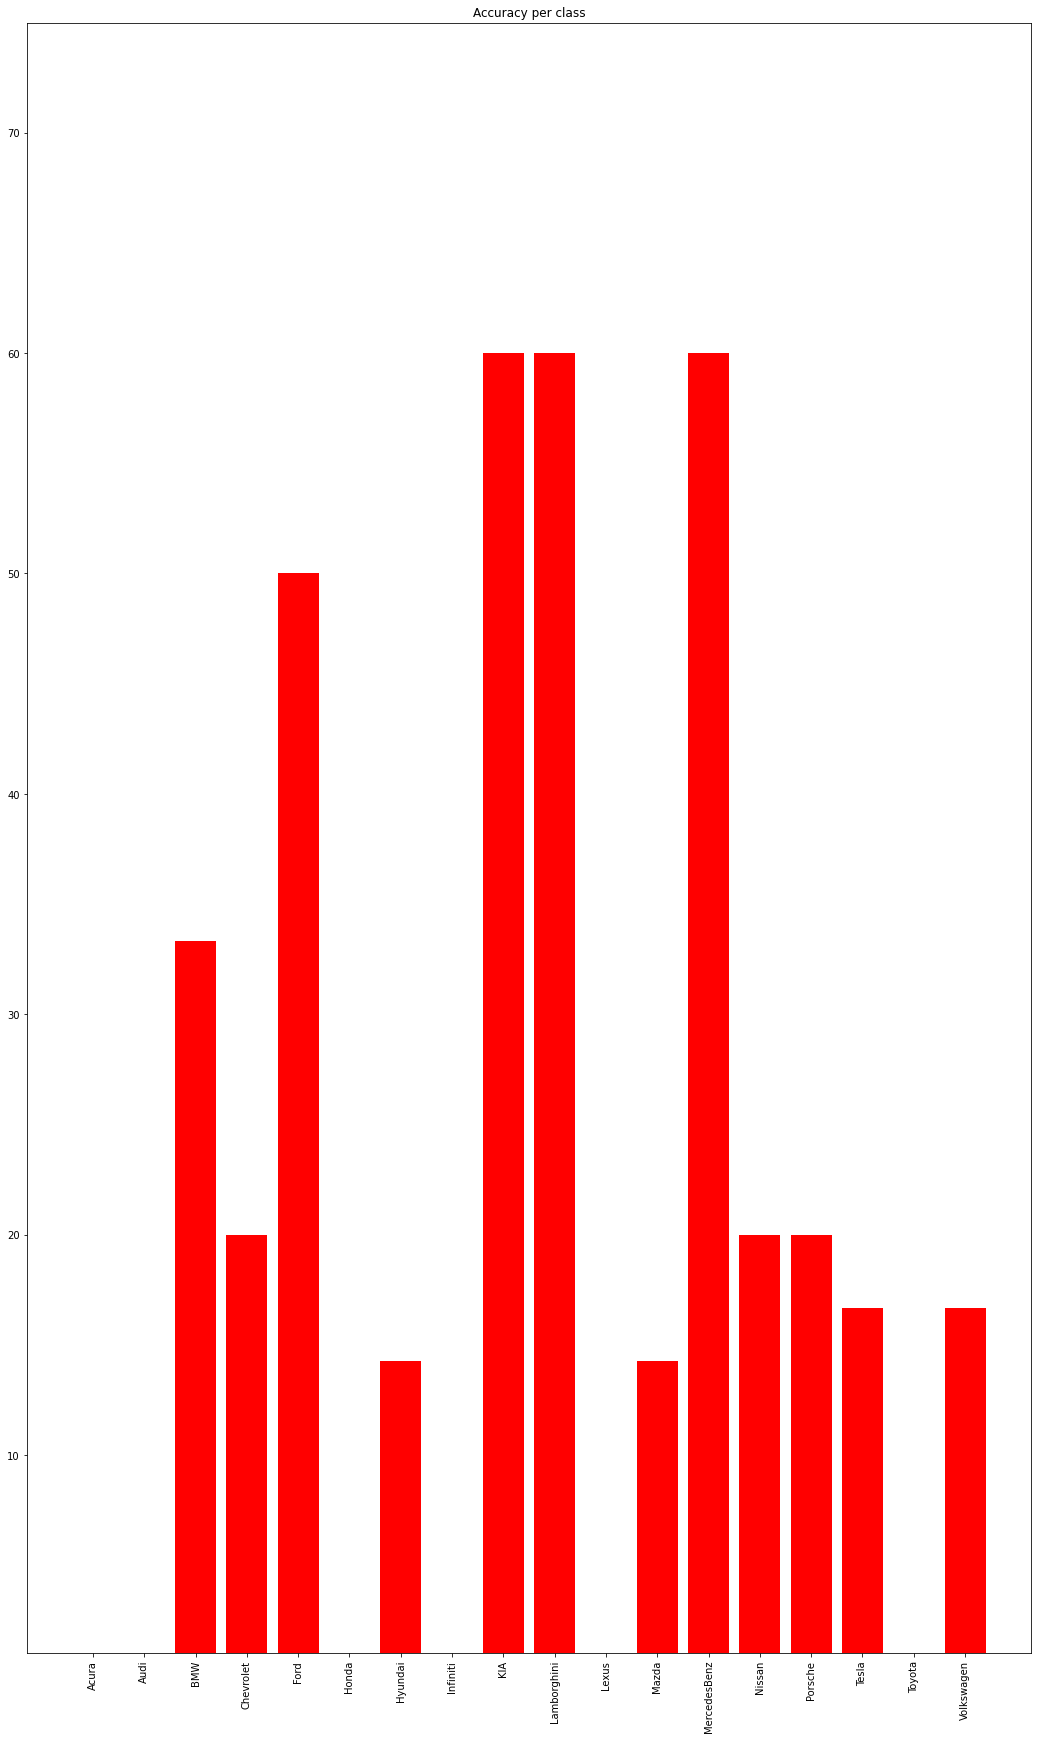

In [ ]:
plt.subplots(figsize=(18,30))
x = range(len(classes))
plt.title('Accuracy per class')
plt.ylim(1, 75)
plt.bar(x, accuracy_per_class, color='Red')
plt.xticks(x, class_name, rotation = 90)
plt.show()